In [2]:
import pandas as pd
print(f'Pandas {pd.__version__}')

import numpy as np
print(f'Numpy {np.__version__}')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, GRU
from tensorflow.keras.utils import plot_model
print(f'Tensorflow {tf.__version__}')

import sklearn
from sklearn.preprocessing import MinMaxScaler
print(f'Sklearn {sklearn.__version__}')

import matplotlib
import matplotlib.pyplot as plt
print(f'Matplotlib {matplotlib.__version__}')

Pandas 1.3.0
Numpy 1.22.0
Tensorflow 2.7.0
Sklearn 1.0.1
Matplotlib 3.5.1


In [3]:
np.random.seed(1234)
tf.random.set_seed(5678)
random_state_seed = 1337

# DATA PREPARATION

In [16]:
df = pd.read_csv('archive/GlobalLandTemperaturesByCountry.csv')
display(df)
#https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth\-surface-temperature-data?select=GlobalTemperatures.csv
#LandAverageTemperature: global average land temperature in celsius
print('Unique country names in the file:', df['Country'].nunique())
#########################################################
df = df[df['Country']=='Thailand']
df = df.reset_index(drop=True)
display(df)
#########################################################
print('#Row contain NaN data in each colunm')
print(df.isnull().sum())
display(df[df['AverageTemperature'].isnull()])
display(df[df['AverageTemperatureUncertainty'].isnull()])
#########################################################
#^uncomment the code above to see NaN data start from index 46 (1820-01-01) to 561 (1862-12-01) and 2370 (2013-09-01)
df = df[562:-1] #so we use data from index 562 to 2369
df = df.reset_index(drop=True)
print(df.isnull().sum())
df

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
...,...,...,...,...
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe
577460,2013-08-01,19.759,0.717,Zimbabwe


Unique country names in the file: 243


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1816-03-01,25.959,1.751,Thailand
1,1816-04-01,27.263,2.960,Thailand
2,1816-05-01,27.932,1.923,Thailand
3,1816-06-01,26.500,1.940,Thailand
4,1816-07-01,25.092,1.605,Thailand
...,...,...,...,...
2366,2013-05-01,29.548,0.286,Thailand
2367,2013-06-01,28.325,0.207,Thailand
2368,2013-07-01,27.564,0.318,Thailand
2369,2013-08-01,27.548,0.289,Thailand


#Row contain NaN data in each colunm
dt                                 0
AverageTemperature               125
AverageTemperatureUncertainty    125
Country                            0
dtype: int64


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
46,1820-01-01,NaN,NaN,Thailand
93,1823-12-01,NaN,NaN,Thailand
94,1824-01-01,NaN,NaN,Thailand
95,1824-02-01,NaN,NaN,Thailand
96,1824-03-01,NaN,NaN,Thailand
...,...,...,...,...
558,1862-09-01,NaN,NaN,Thailand
559,1862-10-01,NaN,NaN,Thailand
560,1862-11-01,NaN,NaN,Thailand
561,1862-12-01,NaN,NaN,Thailand


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
46,1820-01-01,NaN,NaN,Thailand
93,1823-12-01,NaN,NaN,Thailand
94,1824-01-01,NaN,NaN,Thailand
95,1824-02-01,NaN,NaN,Thailand
96,1824-03-01,NaN,NaN,Thailand
...,...,...,...,...
558,1862-09-01,NaN,NaN,Thailand
559,1862-10-01,NaN,NaN,Thailand
560,1862-11-01,NaN,NaN,Thailand
561,1862-12-01,NaN,NaN,Thailand


dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
dtype: int64


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1863-01-01,22.806,2.022,Thailand
1,1863-02-01,24.700,2.396,Thailand
2,1863-03-01,26.599,0.854,Thailand
3,1863-04-01,27.646,1.523,Thailand
4,1863-05-01,27.756,1.296,Thailand
...,...,...,...,...
1803,2013-04-01,29.885,0.234,Thailand
1804,2013-05-01,29.548,0.286,Thailand
1805,2013-06-01,28.325,0.207,Thailand
1806,2013-07-01,27.564,0.318,Thailand


In [68]:
column_data = df['AverageTemperature']

def convertToMatrix(data, feature_timestep):
    x, y = [], []
    for i in range(len(df)-feature_timestep):
        d = i+feature_timestep
        x.append(data[i:d])
        y.append(data[d])
    return np.array(x), np.array(y)
model_structure = 'DEEP RNN'

# 4 TIMESTEPS

In [69]:
feature_timestep = 4
x, y = convertToMatrix(column_data, feature_timestep)


print(f'{feature_timestep} Features')
print(f'Data Length for {feature_timestep} Features: {len(x)}')
print(f'Length x=y: {len(x)==len(y)}')
print(f'{feature_timestep} Features x shape: {x.shape}')
print(f'{feature_timestep} Features y shape: {y.shape}')

4 Features
Data Length for 4 Features: 1804
Length x=y: True
4 Features x shape: (1804, 4)
4 Features y shape: (1804,)


In [70]:
percent_trainset = 0.8
percent_testset = 0.1

rng = np.random.RandomState(random_state_seed)
rng.shuffle(x)
rng = np.random.RandomState(random_state_seed)
rng.shuffle(y)

n_train = int(len(x)*percent_trainset)
n_test = int(len(x)*percent_testset)
n_val = len(x)-n_train-n_test

x_train, y_train = x[:n_train], y[:n_train]
x_val, y_val = x[n_train:n_train+n_val], y[n_train:n_train+n_val]
x_test, y_test = x[n_train+n_val:], y[n_train+n_val:]

print('Split Train/Val/Test')
print(f'{feature_timestep} Features Trainset Shape:',x_train.shape, y_train.shape)
print(f'{feature_timestep} Features Valset Shape:',x_val.shape, y_val.shape)
print(f'{feature_timestep} Features Testset Shape:',x_test.shape, y_test.shape)

Split Train/Val/Test
4 Features Trainset Shape: (1443, 4) (1443,)
4 Features Valset Shape: (181, 4) (181,)
4 Features Testset Shape: (180, 4) (180,)


In [71]:
#normalized all data by x_train
minmax_norm = MinMaxScaler().fit(x_train.reshape(-1,1))

x_train_norm = minmax_norm.transform(x_train.reshape(-1,1)).reshape(-1,feature_timestep)
x_val_norm = minmax_norm.transform(x_val.reshape(-1,1)).reshape(-1,feature_timestep)
x_test_norm = minmax_norm.transform(x_test.reshape(-1,1)).reshape(-1,feature_timestep)

y_train_norm = minmax_norm.transform(y_train.reshape(-1,1)).reshape(-1,1)
y_val_norm = minmax_norm.transform(y_val.reshape(-1,1)).reshape(-1,1)
y_test_norm = minmax_norm.transform(y_test.reshape(-1,1)).reshape(-1,1)

print('x shape before newaxis')
print(x_train_norm.shape)
print(x_val_norm.shape)
print(x_test_norm.shape)

#add new axis
x_train_norm = x_train_norm[..., np.newaxis] 
'''need input as [[],
                  [],
                  [],
                  []] shape=(4,1)
'''
x_val_norm = x_val_norm[..., np.newaxis]
x_test_norm = x_test_norm[..., np.newaxis]

print('x shape after newaxis')
print(x_train_norm.shape) #Final input shape must be (n_sample, n_sequence, n_feature per sequence) https://www.youtube.com/watch?v=EnuAP1ZQb4s
print(x_val_norm.shape)
print(x_test_norm.shape)
print('y shape')
print(y_train_norm.shape)
print(y_val_norm.shape)
print(y_test_norm.shape)

#transform to float32
x_train_norm = x_train_norm.astype(np.float32)
x_val_norm = x_val_norm.astype(np.float32)
x_test_norm = x_test_norm.astype(np.float32)

y_train_norm = y_train_norm.astype(np.float32)
y_val_norm = y_val_norm.astype(np.float32)
y_test_norm = y_test_norm.astype(np.float32)

x shape before newaxis
(1443, 4)
(181, 4)
(180, 4)
x shape after newaxis
(1443, 4, 1)
(181, 4, 1)
(180, 4, 1)
y shape
(1443, 1)
(181, 1)
(180, 1)


In [72]:
%%time
#deep rnn model
model = Sequential()

model.add(SimpleRNN(128, input_shape=(None,1), return_sequences=True))
model.add(Dropout(0.5))

model.add(SimpleRNN(128))
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(Dropout(0.5))

model.add(Dense(1))

model.summary()

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='mean_absolute_error',
    optimizer=opt,
    metrics=['mean_absolute_error'],
)

checkpoint_filepath = 'bestmodel_DeepRNN.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(x_train_norm,
          y_train_norm,
          epochs=100,
          batch_size = 10,
          validation_data=(x_val_norm,y_val_norm),
          callbacks=[model_checkpoint_callback])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, None, 128)         16640     
                                                                 
 dropout_18 (Dropout)        (None, None, 128)         0         
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 128)               32896     
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                

C:\Users\tOm\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


145/145 [==============================] - 10s 49ms/step - loss: 0.4484 - mean_absolute_error: 0.4484 - val_loss: 0.1358 - val_mean_absolute_error: 0.1358
Epoch 2/100
145/145 [==============================] - 6s 44ms/step - loss: 0.2324 - mean_absolute_error: 0.2324 - val_loss: 0.0939 - val_mean_absolute_error: 0.0939
Epoch 3/100
145/145 [==============================] - 6s 45ms/step - loss: 0.1790 - mean_absolute_error: 0.1790 - val_loss: 0.0819 - val_mean_absolute_error: 0.0819
Epoch 4/100
145/145 [==============================] - 6s 44ms/step - loss: 0.1549 - mean_absolute_error: 0.1549 - val_loss: 0.1010 - val_mean_absolute_error: 0.1010
Epoch 5/100
145/145 [==============================] - 6s 45ms/step - loss: 0.1365 - mean_absolute_error: 0.1365 - val_loss: 0.0816 - val_mean_absolute_error: 0.0816
Epoch 6/100
145/145 [==============================] - 7s 45ms/step - loss: 0.1298 - mean_absolute_error: 0.1298 - val_loss: 0.0827 - val_mean_absolute_error: 0.0827
Epoch 7/100
145

145/145 [==============================] - 7s 47ms/step - loss: 0.0861 - mean_absolute_error: 0.0861 - val_loss: 0.0705 - val_mean_absolute_error: 0.0705
Epoch 100/100
145/145 [==============================] - 7s 48ms/step - loss: 0.0854 - mean_absolute_error: 0.0854 - val_loss: 0.0812 - val_mean_absolute_error: 0.0812
Wall time: 11min 28s


In [73]:
#training detail
history.history

{'loss': [0.4484131634235382,
  0.23235845565795898,
  0.17899386584758759,
  0.15490712225437164,
  0.13648748397827148,
  0.12977901101112366,
  0.1175803691148758,
  0.11648713797330856,
  0.11213193088769913,
  0.10739349573850632,
  0.10640354454517365,
  0.10469365119934082,
  0.100023053586483,
  0.0988774523139,
  0.0994027704000473,
  0.09722191095352173,
  0.09411448985338211,
  0.09455636888742447,
  0.0940052941441536,
  0.09327937662601471,
  0.0920858308672905,
  0.09111661463975906,
  0.0904780700802803,
  0.08730553835630417,
  0.08905360102653503,
  0.09011116623878479,
  0.08781712502241135,
  0.09026572853326797,
  0.08779418468475342,
  0.08705724030733109,
  0.08768930286169052,
  0.08847755193710327,
  0.08881067484617233,
  0.08725074678659439,
  0.08932503312826157,
  0.08657507598400116,
  0.08882588148117065,
  0.08688800781965256,
  0.08752425760030746,
  0.0874447152018547,
  0.0865119993686676,
  0.0876033753156662,
  0.08800794184207916,
  0.08895177394151

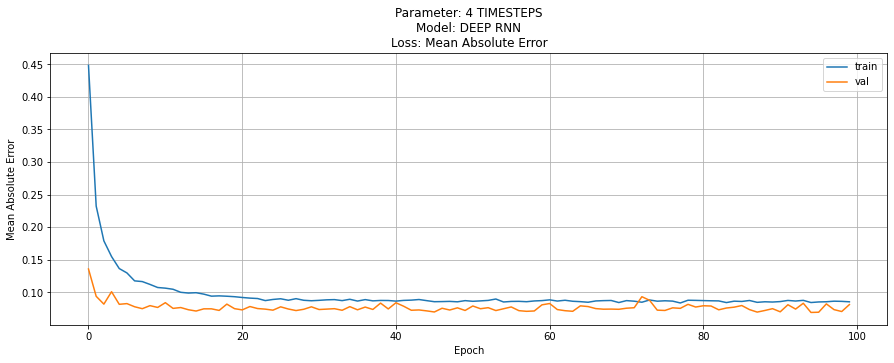

In [74]:
#plot loss, val_loss VS epoch
loss_metric = f'Mean Absolute Error'
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Parameter: {feature_timestep} TIMESTEPS\nModel: {model_structure}\nLoss: {loss_metric}')

plt.ylabel(f'{loss_metric}')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.grid()
plt.show()

In [75]:
#laod best model
model.load_weights(checkpoint_filepath)

loss, metric = model.evaluate(x_test_norm, y_test_norm, verbose=1)
print(f'Model LOSS={loss}, METRIC={metric}')

6/6 [==============================] - 0s 10ms/step - loss: 0.0771 - mean_absolute_error: 0.0771
Model LOSS=0.0771453008055687, METRIC=0.0771453008055687


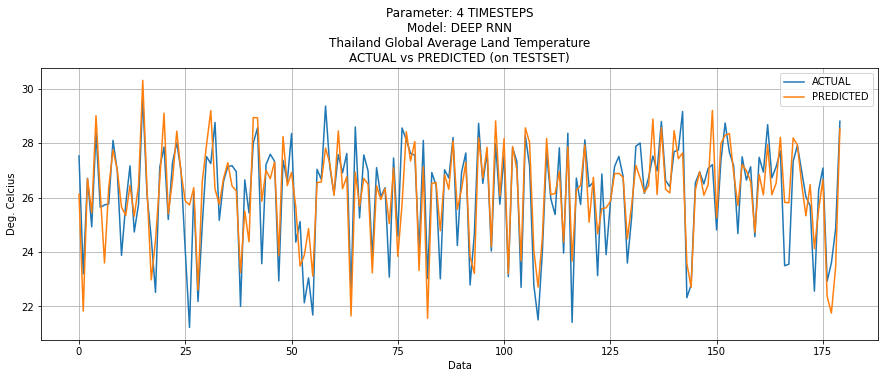

In [76]:
y_test_predict = model.predict(x_test_norm)
y_test_predict_inv = minmax_norm.inverse_transform(y_test_predict)
#print(f'len y_test_true: {len(y_test)}')
#print(f'ldn y_test_predict: {len(y_test_predict_inv)}')

#plot
plt.figure(figsize=(15,5))
plt.plot(y_test)
plt.plot(y_test_predict_inv)
plt.title(f'Parameter: {feature_timestep} TIMESTEPS\nModel: {model_structure}\nThailand Global Average Land Temperature\nACTUAL vs PREDICTED (on TESTSET)')
plt.ylabel('Deg. Celcius')
plt.xlabel('Data')
plt.legend(['ACTUAL','PREDICTED'], loc='upper right')
plt.grid()
plt.show()

In [77]:
#calculate MAE from inverse normalized result
#print(f'len y_test_true: {len(y_test)}')
#print(f'ldn y_test_predict: {len(y_test_predict_inv)}')

mae_testset = []
for i in range(len(y_test)):
    #print(y_test[i])
    #print(y_test_predict_inv[i])
    mae_testset.append(abs(y_test[i]-y_test_predict_inv[i]))
#print(mae_testset)
print(f'MAE Testset = {np.array(mae_testset).mean()}')

MAE Testset = 0.7846448421478271


# 6 TIMESTEPS

In [78]:
feature_timestep = 6
x, y = convertToMatrix(column_data, feature_timestep)


print(f'{feature_timestep} Features')
print(f'Data Length for {feature_timestep} Features: {len(x)}')
print(f'Length x=y: {len(x)==len(y)}')
print(f'{feature_timestep} Features x shape: {x.shape}')
print(f'{feature_timestep} Features y shape: {y.shape}')

6 Features
Data Length for 6 Features: 1802
Length x=y: True
6 Features x shape: (1802, 6)
6 Features y shape: (1802,)


In [79]:
percent_trainset = 0.8
percent_testset = 0.1

rng = np.random.RandomState(random_state_seed)
rng.shuffle(x)
rng = np.random.RandomState(random_state_seed)
rng.shuffle(y)

n_train = int(len(x)*percent_trainset)
n_test = int(len(x)*percent_testset)
n_val = len(x)-n_train-n_test

x_train, y_train = x[:n_train], y[:n_train]
x_val, y_val = x[n_train:n_train+n_val], y[n_train:n_train+n_val]
x_test, y_test = x[n_train+n_val:], y[n_train+n_val:]

print('Split Train/Val/Test')
print(f'{feature_timestep} Features Trainset Shape:',x_train.shape, y_train.shape)
print(f'{feature_timestep} Features Valset Shape:',x_val.shape, y_val.shape)
print(f'{feature_timestep} Features Testset Shape:',x_test.shape, y_test.shape)

Split Train/Val/Test
6 Features Trainset Shape: (1441, 6) (1441,)
6 Features Valset Shape: (181, 6) (181,)
6 Features Testset Shape: (180, 6) (180,)


In [80]:
#normalized all data by x_train
minmax_norm = MinMaxScaler().fit(x_train.reshape(-1,1))

x_train_norm = minmax_norm.transform(x_train.reshape(-1,1)).reshape(-1,feature_timestep)
x_val_norm = minmax_norm.transform(x_val.reshape(-1,1)).reshape(-1,feature_timestep)
x_test_norm = minmax_norm.transform(x_test.reshape(-1,1)).reshape(-1,feature_timestep)

y_train_norm = minmax_norm.transform(y_train.reshape(-1,1)).reshape(-1,1)
y_val_norm = minmax_norm.transform(y_val.reshape(-1,1)).reshape(-1,1)
y_test_norm = minmax_norm.transform(y_test.reshape(-1,1)).reshape(-1,1)

print('x shape before newaxis')
print(x_train_norm.shape)
print(x_val_norm.shape)
print(x_test_norm.shape)

#add new axis
x_train_norm = x_train_norm[..., np.newaxis] 
'''need input as [[],
                  [],
                  [],
                  []] shape=(4,1)
'''
x_val_norm = x_val_norm[..., np.newaxis]
x_test_norm = x_test_norm[..., np.newaxis]

print('x shape after newaxis')
print(x_train_norm.shape) #Final input shape must be (n_sample, n_sequence, n_feature per sequence) https://www.youtube.com/watch?v=EnuAP1ZQb4s
print(x_val_norm.shape)
print(x_test_norm.shape)
print('y shape')
print(y_train_norm.shape)
print(y_val_norm.shape)
print(y_test_norm.shape)

#transform to float32
x_train_norm = x_train_norm.astype(np.float32)
x_val_norm = x_val_norm.astype(np.float32)
x_test_norm = x_test_norm.astype(np.float32)

y_train_norm = y_train_norm.astype(np.float32)
y_val_norm = y_val_norm.astype(np.float32)
y_test_norm = y_test_norm.astype(np.float32)

x shape before newaxis
(1441, 6)
(181, 6)
(180, 6)
x shape after newaxis
(1441, 6, 1)
(181, 6, 1)
(180, 6, 1)
y shape
(1441, 1)
(181, 1)
(180, 1)


In [81]:
%%time
#deep rnn model
model = Sequential()

model.add(SimpleRNN(128, input_shape=(None,1), return_sequences=True))
model.add(Dropout(0.5))

model.add(SimpleRNN(128))
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(Dropout(0.5))

model.add(Dense(1))

model.summary()

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='mean_absolute_error',
    optimizer=opt,
    metrics=['mean_absolute_error'],
)

checkpoint_filepath = 'bestmodel_DeepRNN.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(x_train_norm,
          y_train_norm,
          epochs=100,
          batch_size = 10,
          validation_data=(x_val_norm,y_val_norm),
          callbacks=[model_checkpoint_callback])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_14 (SimpleRNN)   (None, None, 128)         16640     
                                                                 
 dropout_21 (Dropout)        (None, None, 128)         0         
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 128)               32896     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                

C:\Users\tOm\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


145/145 [==============================] - 14s 70ms/step - loss: 0.5359 - mean_absolute_error: 0.5359 - val_loss: 0.1066 - val_mean_absolute_error: 0.1066
Epoch 2/100
145/145 [==============================] - 10s 70ms/step - loss: 0.2586 - mean_absolute_error: 0.2586 - val_loss: 0.1223 - val_mean_absolute_error: 0.1223
Epoch 3/100
145/145 [==============================] - 10s 67ms/step - loss: 0.1937 - mean_absolute_error: 0.1937 - val_loss: 0.0881 - val_mean_absolute_error: 0.0881
Epoch 4/100
145/145 [==============================] - 10s 67ms/step - loss: 0.1594 - mean_absolute_error: 0.1594 - val_loss: 0.0852 - val_mean_absolute_error: 0.0852
Epoch 5/100
145/145 [==============================] - 10s 67ms/step - loss: 0.1389 - mean_absolute_error: 0.1389 - val_loss: 0.0849 - val_mean_absolute_error: 0.0849
Epoch 6/100
145/145 [==============================] - 9s 65ms/step - loss: 0.1259 - mean_absolute_error: 0.1259 - val_loss: 0.0863 - val_mean_absolute_error: 0.0863
Epoch 7/100

145/145 [==============================] - 10s 66ms/step - loss: 0.0821 - mean_absolute_error: 0.0821 - val_loss: 0.0746 - val_mean_absolute_error: 0.0746
Epoch 51/100
145/145 [==============================] - 10s 70ms/step - loss: 0.0819 - mean_absolute_error: 0.0819 - val_loss: 0.0708 - val_mean_absolute_error: 0.0708
Epoch 52/100
145/145 [==============================] - 10s 71ms/step - loss: 0.0829 - mean_absolute_error: 0.0829 - val_loss: 0.0805 - val_mean_absolute_error: 0.0805
Epoch 53/100
145/145 [==============================] - 9s 63ms/step - loss: 0.0805 - mean_absolute_error: 0.0805 - val_loss: 0.0755 - val_mean_absolute_error: 0.0755
Epoch 54/100
145/145 [==============================] - 10s 70ms/step - loss: 0.0818 - mean_absolute_error: 0.0818 - val_loss: 0.0731 - val_mean_absolute_error: 0.0731
Epoch 55/100
145/145 [==============================] - 10s 67ms/step - loss: 0.0812 - mean_absolute_error: 0.0812 - val_loss: 0.0854 - val_mean_absolute_error: 0.0854
Epoch 

Epoch 99/100
145/145 [==============================] - 10s 68ms/step - loss: 0.0808 - mean_absolute_error: 0.0808 - val_loss: 0.0774 - val_mean_absolute_error: 0.0774
Epoch 100/100
145/145 [==============================] - 11s 73ms/step - loss: 0.0808 - mean_absolute_error: 0.0808 - val_loss: 0.0719 - val_mean_absolute_error: 0.0719
Wall time: 16min 6s


In [82]:
#training detail
history.history

{'loss': [0.5358800888061523,
  0.2585883140563965,
  0.19372624158859253,
  0.15937617421150208,
  0.13886083662509918,
  0.12586262822151184,
  0.11669207364320755,
  0.10741789638996124,
  0.10798624902963638,
  0.10023440420627594,
  0.10023190081119537,
  0.09471350908279419,
  0.09285705536603928,
  0.09268611669540405,
  0.09134907275438309,
  0.08864230662584305,
  0.0889122411608696,
  0.08806060254573822,
  0.08512356877326965,
  0.08401627838611603,
  0.08558923751115799,
  0.08561667054891586,
  0.0835992768406868,
  0.08336459845304489,
  0.08517006784677505,
  0.08385153114795685,
  0.08313732594251633,
  0.0835699513554573,
  0.08296535909175873,
  0.08080622553825378,
  0.08227219432592392,
  0.08027740567922592,
  0.08015316724777222,
  0.08217337727546692,
  0.08086606860160828,
  0.08079872280359268,
  0.08177392929792404,
  0.08079178631305695,
  0.08246304094791412,
  0.08171923458576202,
  0.0824737623333931,
  0.07947514206171036,
  0.08159574866294861,
  0.08178

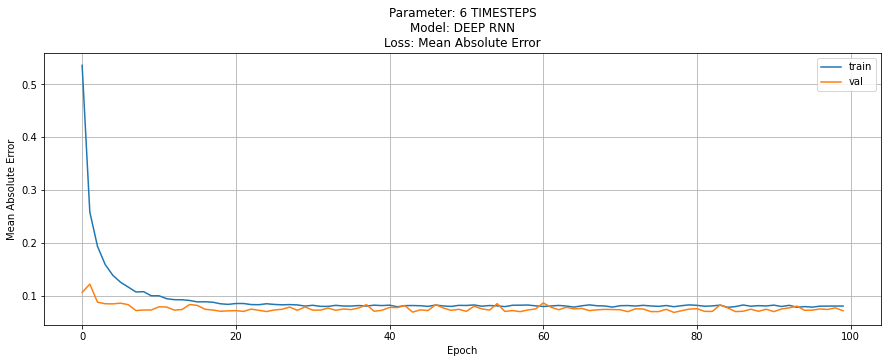

In [83]:
#plot loss, val_loss VS epoch
loss_metric = f'Mean Absolute Error'
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Parameter: {feature_timestep} TIMESTEPS\nModel: {model_structure}\nLoss: {loss_metric}')

plt.ylabel(f'{loss_metric}')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.grid()
plt.show()

In [84]:
#laod best model
model.load_weights(checkpoint_filepath)

loss, metric = model.evaluate(x_test_norm, y_test_norm, verbose=1)
print(f'Model LOSS={loss}, METRIC={metric}')

6/6 [==============================] - 0s 14ms/step - loss: 0.0639 - mean_absolute_error: 0.0639
Model LOSS=0.06388045847415924, METRIC=0.06388045847415924


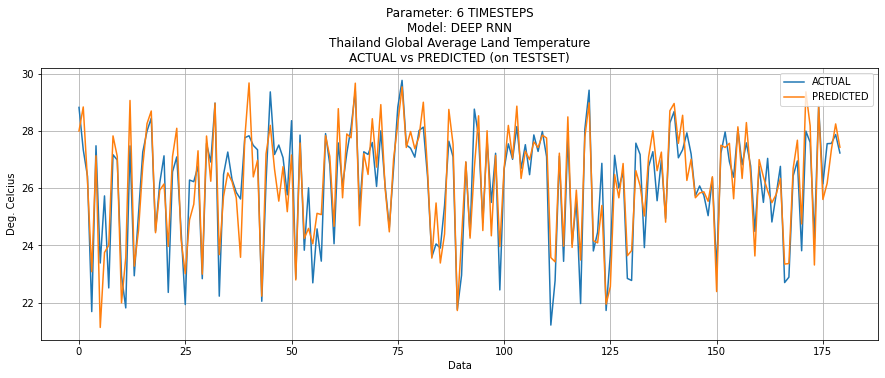

In [85]:
y_test_predict = model.predict(x_test_norm)
y_test_predict_inv = minmax_norm.inverse_transform(y_test_predict)
#print(f'len y_test_true: {len(y_test)}')
#print(f'ldn y_test_predict: {len(y_test_predict_inv)}')

#plot
plt.figure(figsize=(15,5))
plt.plot(y_test)
plt.plot(y_test_predict_inv)
plt.title(f'Parameter: {feature_timestep} TIMESTEPS\nModel: {model_structure}\nThailand Global Average Land Temperature\nACTUAL vs PREDICTED (on TESTSET)')
plt.ylabel('Deg. Celcius')
plt.xlabel('Data')
plt.legend(['ACTUAL','PREDICTED'], loc='upper right')
plt.grid()
plt.show()

In [86]:
#calculate MAE from inverse normalized result
#print(f'len y_test_true: {len(y_test)}')
#print(f'ldn y_test_predict: {len(y_test_predict_inv)}')

mae_testset = []
for i in range(len(y_test)):
    #print(y_test[i])
    #print(y_test_predict_inv[i])
    mae_testset.append(abs(y_test[i]-y_test_predict_inv[i]))
#print(mae_testset)
print(f'MAE Testset = {np.array(mae_testset).mean()}')

MAE Testset = 0.6497282385826111


# 12 TIMESTEPS

In [87]:
feature_timestep = 12
x, y = convertToMatrix(column_data, feature_timestep)


print(f'{feature_timestep} Features')
print(f'Data Length for {feature_timestep} Features: {len(x)}')
print(f'Length x=y: {len(x)==len(y)}')
print(f'{feature_timestep} Features x shape: {x.shape}')
print(f'{feature_timestep} Features y shape: {y.shape}')

12 Features
Data Length for 12 Features: 1796
Length x=y: True
12 Features x shape: (1796, 12)
12 Features y shape: (1796,)


In [88]:
percent_trainset = 0.8
percent_testset = 0.1

rng = np.random.RandomState(random_state_seed)
rng.shuffle(x)
rng = np.random.RandomState(random_state_seed)
rng.shuffle(y)

n_train = int(len(x)*percent_trainset)
n_test = int(len(x)*percent_testset)
n_val = len(x)-n_train-n_test

x_train, y_train = x[:n_train], y[:n_train]
x_val, y_val = x[n_train:n_train+n_val], y[n_train:n_train+n_val]
x_test, y_test = x[n_train+n_val:], y[n_train+n_val:]

print('Split Train/Val/Test')
print(f'{feature_timestep} Features Trainset Shape:',x_train.shape, y_train.shape)
print(f'{feature_timestep} Features Valset Shape:',x_val.shape, y_val.shape)
print(f'{feature_timestep} Features Testset Shape:',x_test.shape, y_test.shape)

Split Train/Val/Test
12 Features Trainset Shape: (1436, 12) (1436,)
12 Features Valset Shape: (181, 12) (181,)
12 Features Testset Shape: (179, 12) (179,)


In [89]:
#normalized all data by x_train
minmax_norm = MinMaxScaler().fit(x_train.reshape(-1,1))

x_train_norm = minmax_norm.transform(x_train.reshape(-1,1)).reshape(-1,feature_timestep)
x_val_norm = minmax_norm.transform(x_val.reshape(-1,1)).reshape(-1,feature_timestep)
x_test_norm = minmax_norm.transform(x_test.reshape(-1,1)).reshape(-1,feature_timestep)

y_train_norm = minmax_norm.transform(y_train.reshape(-1,1)).reshape(-1,1)
y_val_norm = minmax_norm.transform(y_val.reshape(-1,1)).reshape(-1,1)
y_test_norm = minmax_norm.transform(y_test.reshape(-1,1)).reshape(-1,1)

print('x shape before newaxis')
print(x_train_norm.shape)
print(x_val_norm.shape)
print(x_test_norm.shape)

#add new axis
x_train_norm = x_train_norm[..., np.newaxis] 
'''need input as [[],
                  [],
                  [],
                  []] shape=(4,1)
'''
x_val_norm = x_val_norm[..., np.newaxis]
x_test_norm = x_test_norm[..., np.newaxis]

print('x shape after newaxis')
print(x_train_norm.shape) #Final input shape must be (n_sample, n_sequence, n_feature per sequence) https://www.youtube.com/watch?v=EnuAP1ZQb4s
print(x_val_norm.shape)
print(x_test_norm.shape)
print('y shape')
print(y_train_norm.shape)
print(y_val_norm.shape)
print(y_test_norm.shape)

#transform to float32
x_train_norm = x_train_norm.astype(np.float32)
x_val_norm = x_val_norm.astype(np.float32)
x_test_norm = x_test_norm.astype(np.float32)

y_train_norm = y_train_norm.astype(np.float32)
y_val_norm = y_val_norm.astype(np.float32)
y_test_norm = y_test_norm.astype(np.float32)

x shape before newaxis
(1436, 12)
(181, 12)
(179, 12)
x shape after newaxis
(1436, 12, 1)
(181, 12, 1)
(179, 12, 1)
y shape
(1436, 1)
(181, 1)
(179, 1)


In [90]:
%%time
#deep rnn model
model = Sequential()

model.add(SimpleRNN(128, input_shape=(None,1), return_sequences=True))
model.add(Dropout(0.5))

model.add(SimpleRNN(128))
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(Dropout(0.5))

model.add(Dense(1))

model.summary()

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='mean_absolute_error',
    optimizer=opt,
    metrics=['mean_absolute_error'],
)

checkpoint_filepath = 'bestmodel_DeepRNN.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint\
(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(x_train_norm,
          y_train_norm,
          epochs=100,
          batch_size = 10,
          validation_data=(x_val_norm,y_val_norm),
          callbacks=[model_checkpoint_callback])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_16 (SimpleRNN)   (None, None, 128)         16640     
                                                                 
 dropout_24 (Dropout)        (None, None, 128)         0         
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, 128)               32896     
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                

C:\Users\tOm\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


144/144 [==============================] - 23s 136ms/step - loss: 0.7825 - mean_absolute_error: 0.7825 - val_loss: 0.1937 - val_mean_absolute_error: 0.1937
Epoch 2/100
144/144 [==============================] - 16s 114ms/step - loss: 0.3380 - mean_absolute_error: 0.3380 - val_loss: 0.0793 - val_mean_absolute_error: 0.0793
Epoch 3/100
144/144 [==============================] - 16s 110ms/step - loss: 0.2144 - mean_absolute_error: 0.2144 - val_loss: 0.0868 - val_mean_absolute_error: 0.0868
Epoch 4/100
144/144 [==============================] - 18s 125ms/step - loss: 0.1676 - mean_absolute_error: 0.1676 - val_loss: 0.0586 - val_mean_absolute_error: 0.0586
Epoch 5/100
144/144 [==============================] - 18s 125ms/step - loss: 0.1416 - mean_absolute_error: 0.1416 - val_loss: 0.0572 - val_mean_absolute_error: 0.0572
Epoch 6/100
144/144 [==============================] - 16s 112ms/step - loss: 0.1209 - mean_absolute_error: 0.1209 - val_loss: 0.0617 - val_mean_absolute_error: 0.0617
Epoc

144/144 [==============================] - 18s 123ms/step - loss: 0.0611 - mean_absolute_error: 0.0611 - val_loss: 0.0528 - val_mean_absolute_error: 0.0528
Epoch 98/100
144/144 [==============================] - 17s 117ms/step - loss: 0.0607 - mean_absolute_error: 0.0607 - val_loss: 0.0450 - val_mean_absolute_error: 0.0450
Epoch 99/100
144/144 [==============================] - 17s 121ms/step - loss: 0.0600 - mean_absolute_error: 0.0600 - val_loss: 0.0595 - val_mean_absolute_error: 0.0595
Epoch 100/100
144/144 [==============================] - 18s 123ms/step - loss: 0.0617 - mean_absolute_error: 0.0617 - val_loss: 0.0519 - val_mean_absolute_error: 0.0519
Wall time: 27min 54s


In [91]:
#training detail
history.history

{'loss': [0.7825013995170593,
  0.33802279829978943,
  0.2144058495759964,
  0.16762778162956238,
  0.14164499938488007,
  0.12086240202188492,
  0.11525199562311172,
  0.10388873517513275,
  0.09878650307655334,
  0.0906480997800827,
  0.09135649353265762,
  0.08446776866912842,
  0.08402629941701889,
  0.08090188354253769,
  0.07845690101385117,
  0.0761059820652008,
  0.07527737319469452,
  0.07205722481012344,
  0.07179117947816849,
  0.0702117383480072,
  0.07074715942144394,
  0.06814649701118469,
  0.066899873316288,
  0.07031290233135223,
  0.06575820595026016,
  0.06627609580755234,
  0.06753700226545334,
  0.06592784821987152,
  0.06702753901481628,
  0.06578270345926285,
  0.06608537584543228,
  0.06527815014123917,
  0.06757692992687225,
  0.06432882696390152,
  0.06400257349014282,
  0.06517060101032257,
  0.06735266000032425,
  0.06677834689617157,
  0.0672985091805458,
  0.06580270081758499,
  0.06707845628261566,
  0.06869078427553177,
  0.0665370374917984,
  0.06718920

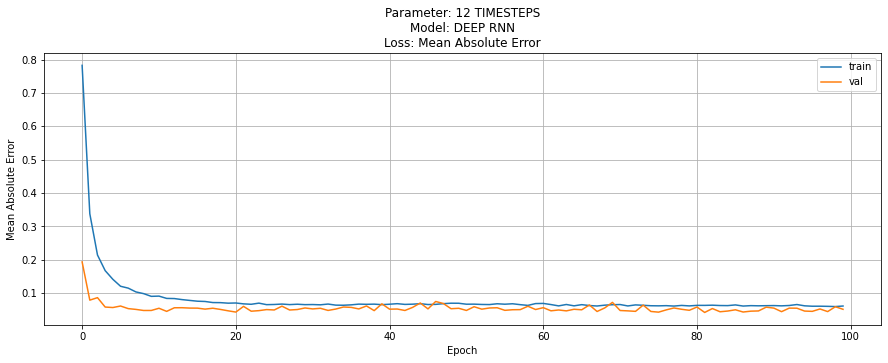

In [98]:
#plot loss, val_loss VS epoch
loss_metric = f'Mean Absolute Error'
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Parameter: {feature_timestep} TIMESTEPS\n\
Model: {model_structure}\nLoss: {loss_metric}')

plt.ylabel(f'{loss_metric}')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.grid()
plt.show()

In [93]:
#lood best model
model.load_weights(checkpoint_filepath)

loss, metric = model.evaluate(x_test_norm, y_test_norm, verbose=1)
print(f'Model LOSS={loss}, METRIC={metric}')

6/6 [==============================] - 0s 23ms/step - loss: 0.0507 - mean_absolute_error: 0.0507
Model LOSS=0.050728268921375275, METRIC=0.050728268921375275


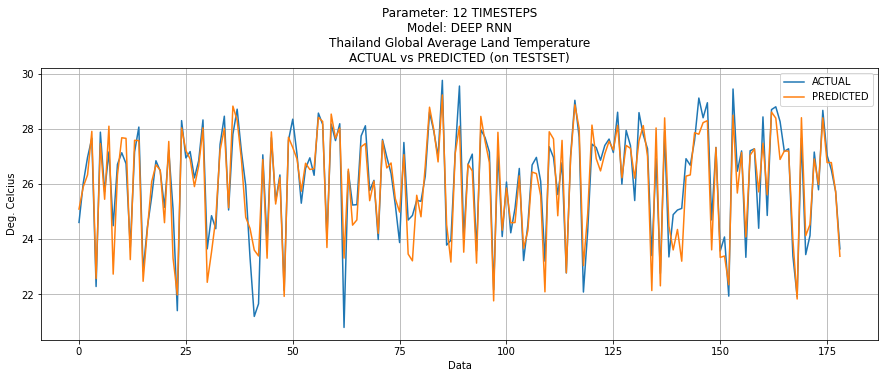

In [94]:
y_test_predict = model.predict(x_test_norm)
y_test_predict_inv = minmax_norm.inverse_transform(y_test_predict)
#print(f'len y_test_true: {len(y_test)}')
#print(f'ldn y_test_predict: {len(y_test_predict_inv)}')

#plot
plt.figure(figsize=(15,5))
plt.plot(y_test)
plt.plot(y_test_predict_inv)
plt.title(f'Parameter: {feature_timestep} TIMESTEPS\nModel: {model_structure}\nThailand Global Average Land Temperature\nACTUAL vs PREDICTED (on TESTSET)')
plt.ylabel('Deg. Celcius')
plt.xlabel('Data')
plt.legend(['ACTUAL','PREDICTED'], loc='upper right')
plt.grid()
plt.show()

In [95]:
#calculate MAE from inverse normalized result
#print(f'len y_test_true: {len(y_test)}')
#print(f'ldn y_test_predict: {len(y_test_predict_inv)}')

mae_testset = []
for i in range(len(y_test)):
    #print(y_test[i])
    #print(y_test_predict_inv[i])
    mae_testset.append(abs(y_test[i]-y_test_predict_inv[i]))
#print(mae_testset)
print(f'MAE Testset = {np.array(mae_testset).mean()}')

MAE Testset = 0.5159572958946228


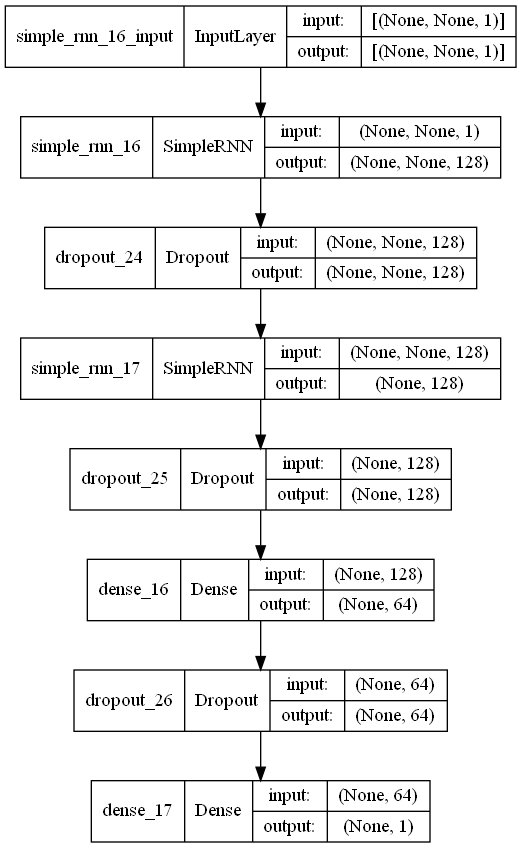

In [96]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot_DeepRNN.png', show_shapes=True, show_layer_names=True)

In [99]:
'''
4: MAE Testset = 0.7846448421478271
6: MAE Testset = 0.6497282385826111
12: MAE Testset = 0.5159572958946228
'''

'\n4: MAE Testset = 0.7846448421478271\n6: MAE Testset = 0.6497282385826111\n12: MAE Testset = 0.5159572958946228\n'